*Эксплуатационная практика Шебанова Вячеслава 15 вариант "Применение нейронных сетей для прогнозирования потребности в кадровых ресурсах"*

*Установление библиотек*

In [12]:

%pip install numpy pandas matplotlib seaborn scikit-learn tensorflow statsmodels jupyter --quiet

print("Все библиотеки установлены!")

Note: you may need to restart the kernel to use updated packages.
Все библиотеки установлены!



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\Machcreator\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


*Импорт библиотек*

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, Attention, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from statsmodels.tsa.seasonal import seasonal_decompose

print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {'Да' if tf.config.list_physical_devices('GPU') else 'Нет'}")
print("Готово к работе!")

TensorFlow: 2.15.0
GPU: Нет
Готово к работе!


*Генерация данных (тренд, шум, сезонность, потребность)*

In [14]:
np.random.seed(42)
dates = pd.date_range(start='2018-01-01', periods=84, freq='M')
n = len(dates)

# Тренд: рост на 3 человека в месяц
trend = 120 + 3 * np.arange(n)

# Сезонность: пик в сентябре-октябре (набор), спад в январе
seasonality = 20 * np.sin(2 * np.pi * (np.arange(n) % 12) / 12) + \
              15 * np.sin(4 * np.pi * (np.arange(n) % 12) / 12)

# Шум
noise = np.random.normal(0, 5, n)

# Итоговая потребность
demand = trend + seasonality + noise
demand = np.round(demand).astype(int)
demand = np.clip(demand, 100, None)

df = pd.DataFrame({'date': dates, 'demand': demand})
df.set_index('date', inplace=True)

print("Данные сгенерированы:")
display(df.head(10))



Данные сгенерированы:


,demand
date,
2018-01-31,122
2018-02-28,145
2018-03-31,160
2018-04-30,157
2018-05-31,135
2018-06-30,131
2018-07-31,146
2018-08-31,148
2018-09-30,137


*Визуализация сгенерированных данных*

In [15]:

import os
from IPython.display import Image, display

def save_and_show(fig, filename, title=""):
    """
    Сохраняет график в results/ и показывает в ноутбуке
    """
    filepath = f'results/{filename}'
    fig.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close(fig)  # Закрываем, чтобы не дублировать
    print(f"Сохранено: {filepath}")
    if title:
        print(f"Описание: {title}\n")
    display(Image(filepath))

Сохранено: results/data_components.png
Описание: Рис. 1 – Декомпозиция сгенерированных данных: тренд, сезонность, шум, итог



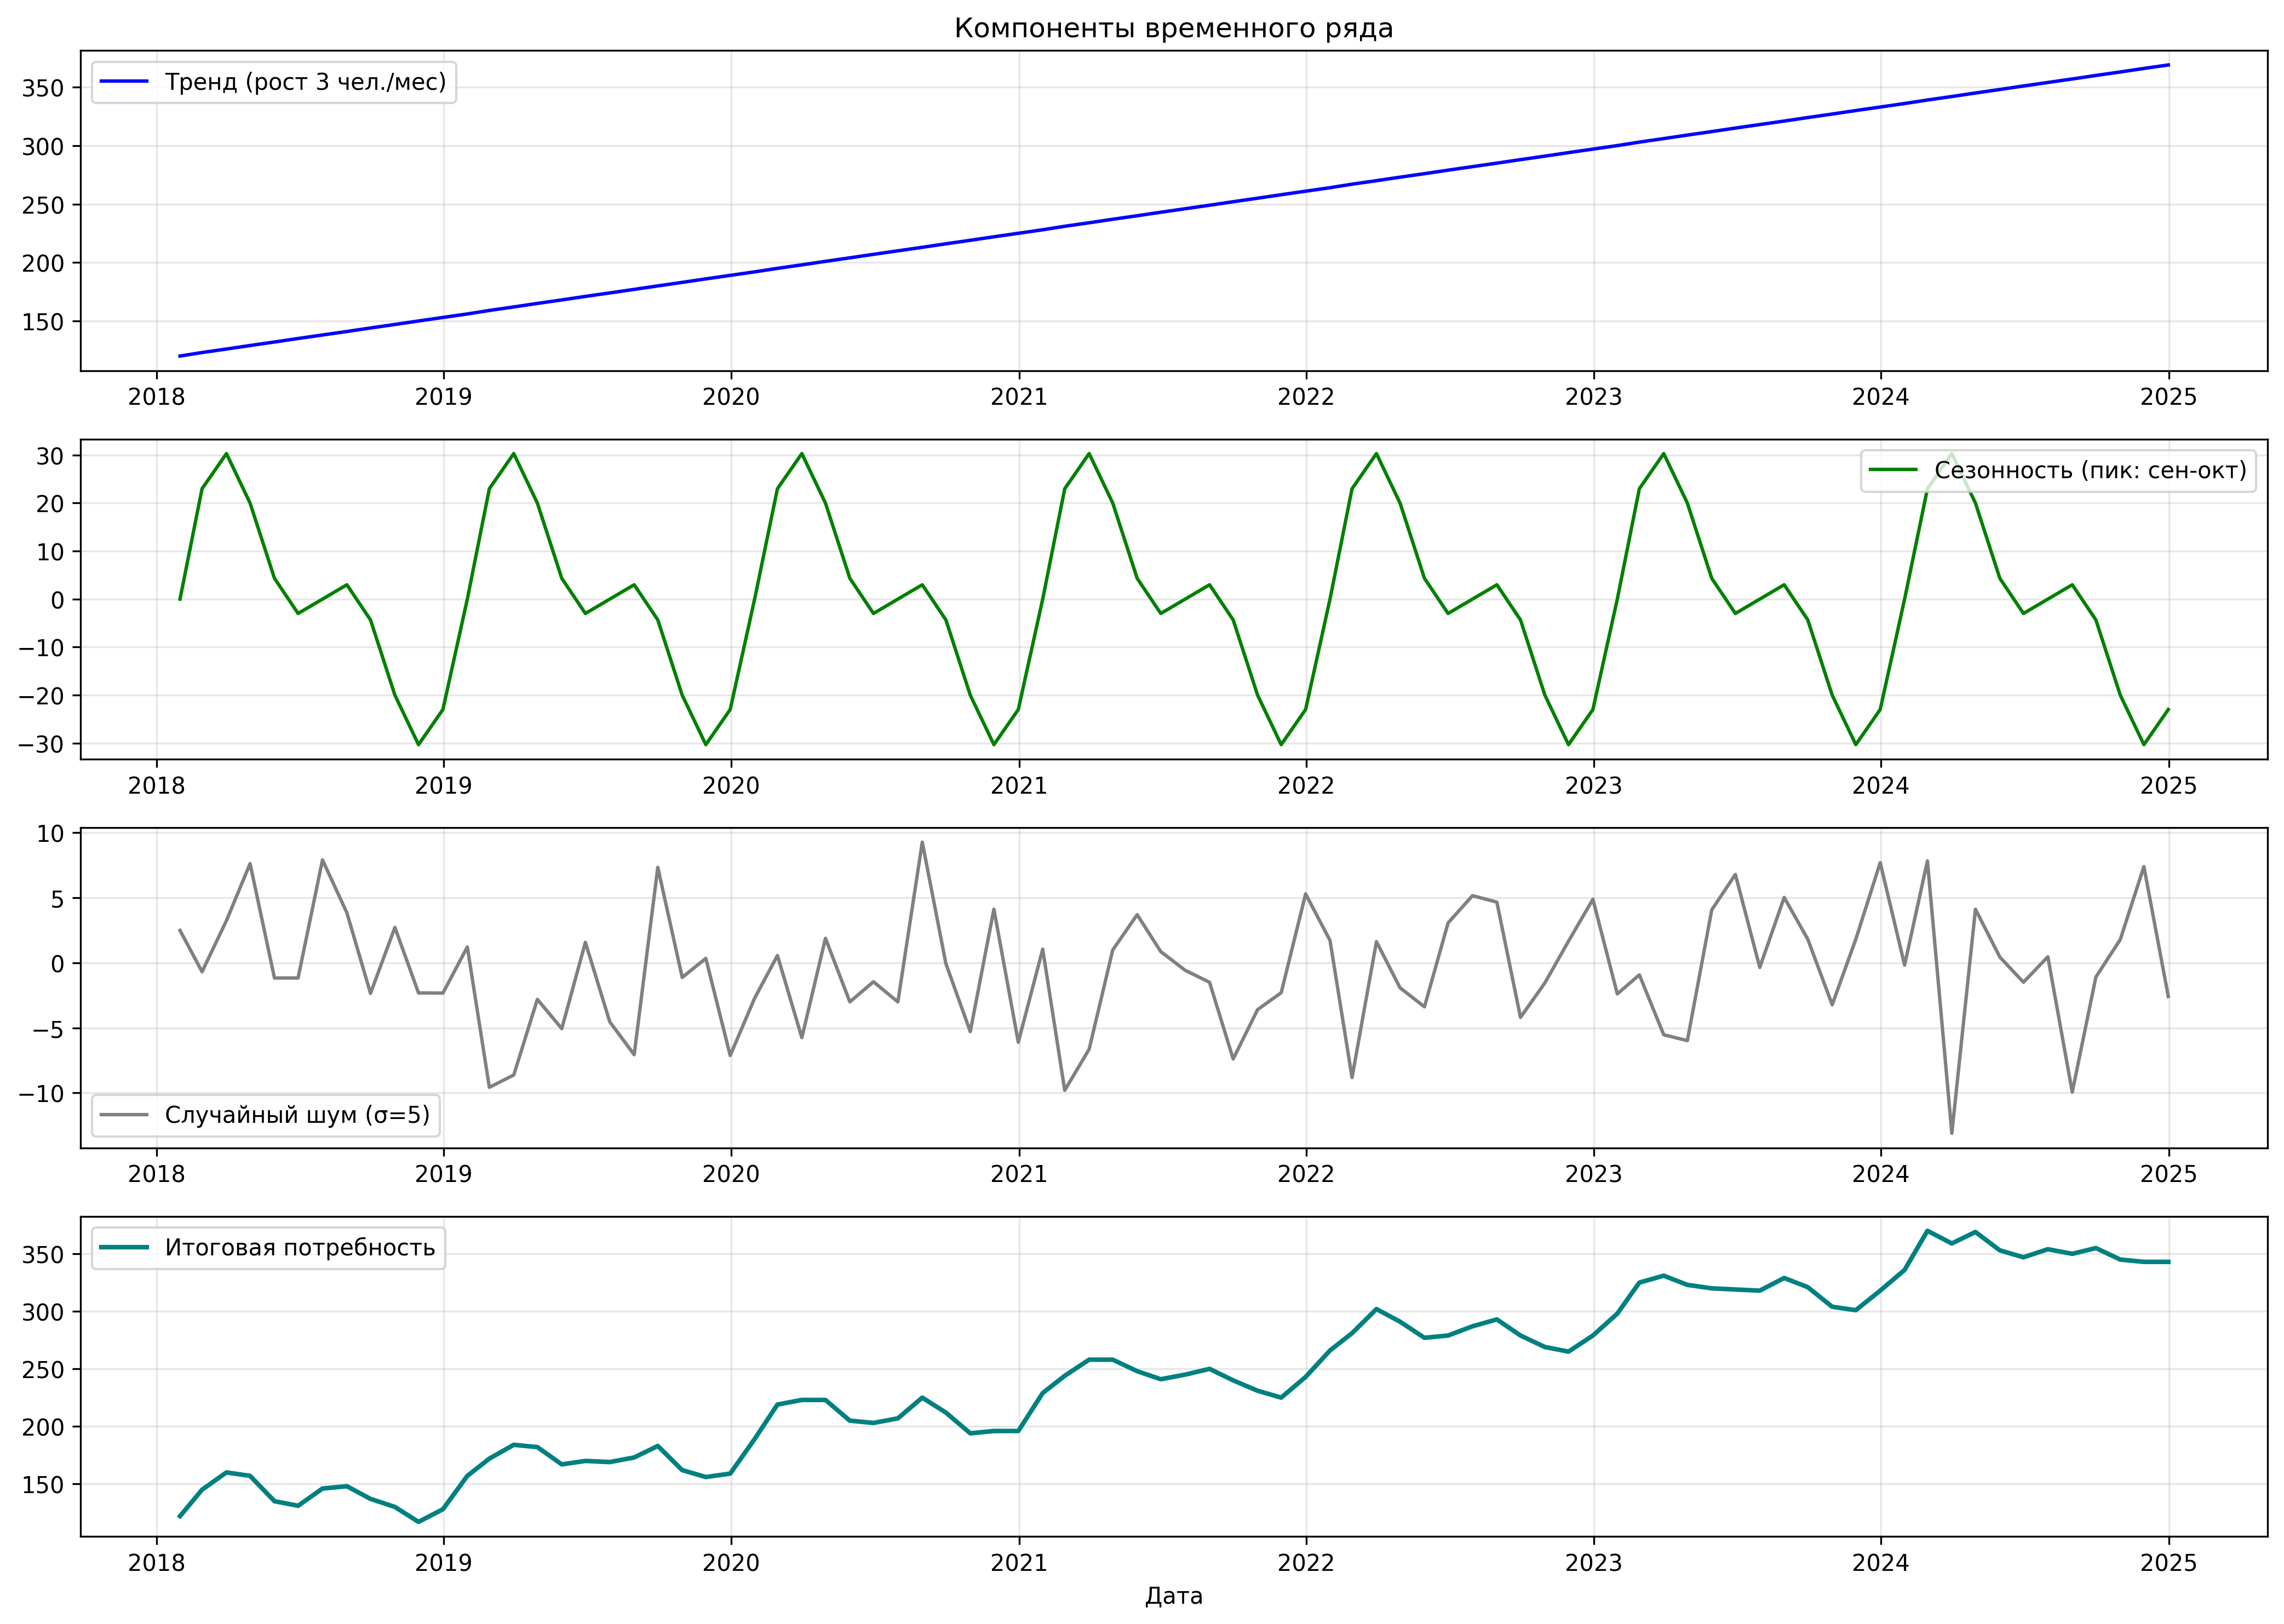

In [16]:

fig, ax = plt.subplots(4, 1, figsize=(14, 10))

ax[0].plot(dates, trend, label='Тренд (рост 3 чел./мес)', color='blue')
ax[0].set_title('Компоненты временного ряда')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

ax[1].plot(dates, seasonality, label='Сезонность (пик: сен-окт)', color='green')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

ax[2].plot(dates, noise, label='Случайный шум (σ=5)', color='gray')
ax[2].legend()
ax[2].grid(True, alpha=0.3)

ax[3].plot(dates, demand, label='Итоговая потребность', color='teal', linewidth=2)
ax[3].set_xlabel('Дата')
ax[3].legend()
ax[3].grid(True, alpha=0.3)

plt.tight_layout()

# === СОХРАНЕНИЕ И ПОКАЗ ===
save_and_show(plt.gcf(), 'data_components.png', 
              "Рис. 1 – Декомпозиция сгенерированных данных: тренд, сезонность, шум, итог")

*Анализ временных рядов с визуализацией*

Папки созданы: results/, models/, data/


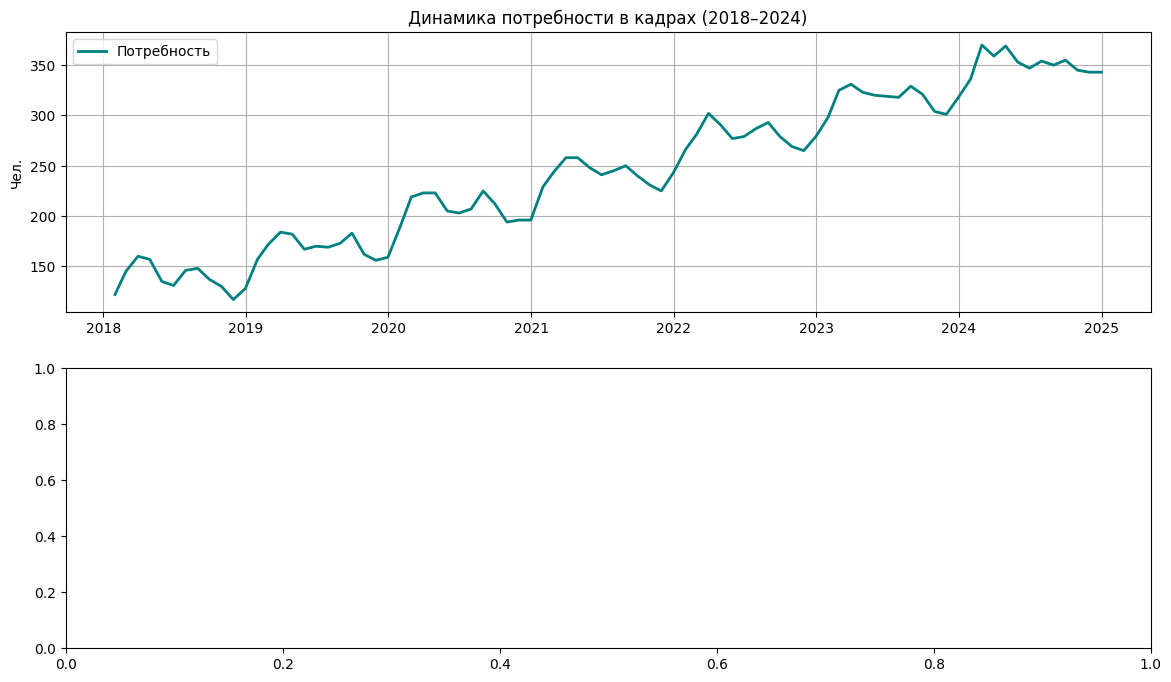

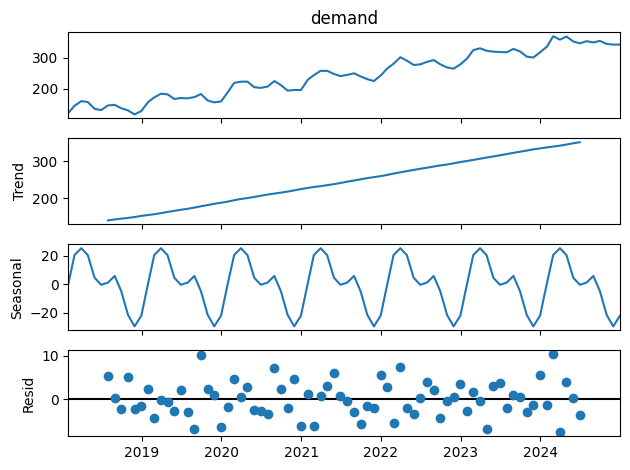

In [17]:
import os
for folder in ['results', 'models', 'data']:
    os.makedirs(folder, exist_ok=True)
# Создаём нужные папки
os.makedirs("results", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("data", exist_ok=True)

print("Папки созданы: results/, models/, data/")

fig, ax = plt.subplots(2, 1, figsize=(14, 8))

# Полный график
ax[0].plot(df.index, df['demand'], label='Потребность', color='teal', linewidth=2)
ax[0].set_title('Динамика потребности в кадрах (2018–2024)')
ax[0].set_ylabel('Чел.')
ax[0].legend()
ax[0].grid(True)

# Декомпозиция
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df['demand'], model='additive', period=12)
decomp.plot()
plt.tight_layout()
plt.savefig('results/decomposition.png', dpi=300)
plt.show()

*Подготовка данных*

In [18]:
def create_features(df):
    df = df.copy()
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['lag_1'] = df['demand'].shift(1)
    df['lag_12'] = df['demand'].shift(12)
    df['rolling_mean_3'] = df['demand'].rolling(3).mean()
    df['rolling_std_6'] = df['demand'].rolling(6).std()
    return df.dropna()

df_features = create_features(df)
print("Фичи добавлены:")
display(df_features.tail())

# Масштабирование
scaler_demand = MinMaxScaler()
scaler_features = StandardScaler()

target = df_features[['demand']]
features = df_features.drop('demand', axis=1)

target_scaled = scaler_demand.fit_transform(target)
features_scaled = scaler_features.fit_transform(features)

# Создание последовательностей
def create_sequences_multivariate(target, features, seq_length=12):
    X, y = [], []
    for i in range(seq_length, len(target)):
        X.append(np.hstack([target[i-seq_length:i], features[i-seq_length:i]]))
        y.append(target[i])
    return np.array(X), np.array(y)

SEQ_LENGTH = 12
X, y = create_sequences_multivariate(target_scaled, features_scaled, SEQ_LENGTH)

# Разделение
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

Фичи добавлены:


,demand,month,quarter,year,lag_1,lag_12,rolling_mean_3,rolling_std_6
date,,,,,,,,
2024-08-31,350,8,3,2024,354.0,329.0,350.333333,7.814516
2024-09-30,355,9,3,2024,350.0,321.0,353.000000,7.607014
2024-10-31,345,10,4,2024,355.0,304.0,350.000000,4.033196
2024-11-30,343,11,4,2024,345.0,301.0,347.666667,4.857983
2024-12-31,343,12,4,2024,343.0,318.0,343.666667,5.428321


X_train: (48, 12, 8), X_test: (12, 12, 8)


*Визуализация подготовки данных*

Сохранено: results/demand_distribution.png
Описание: Гистограмма распределения спроса с нормальным приближением



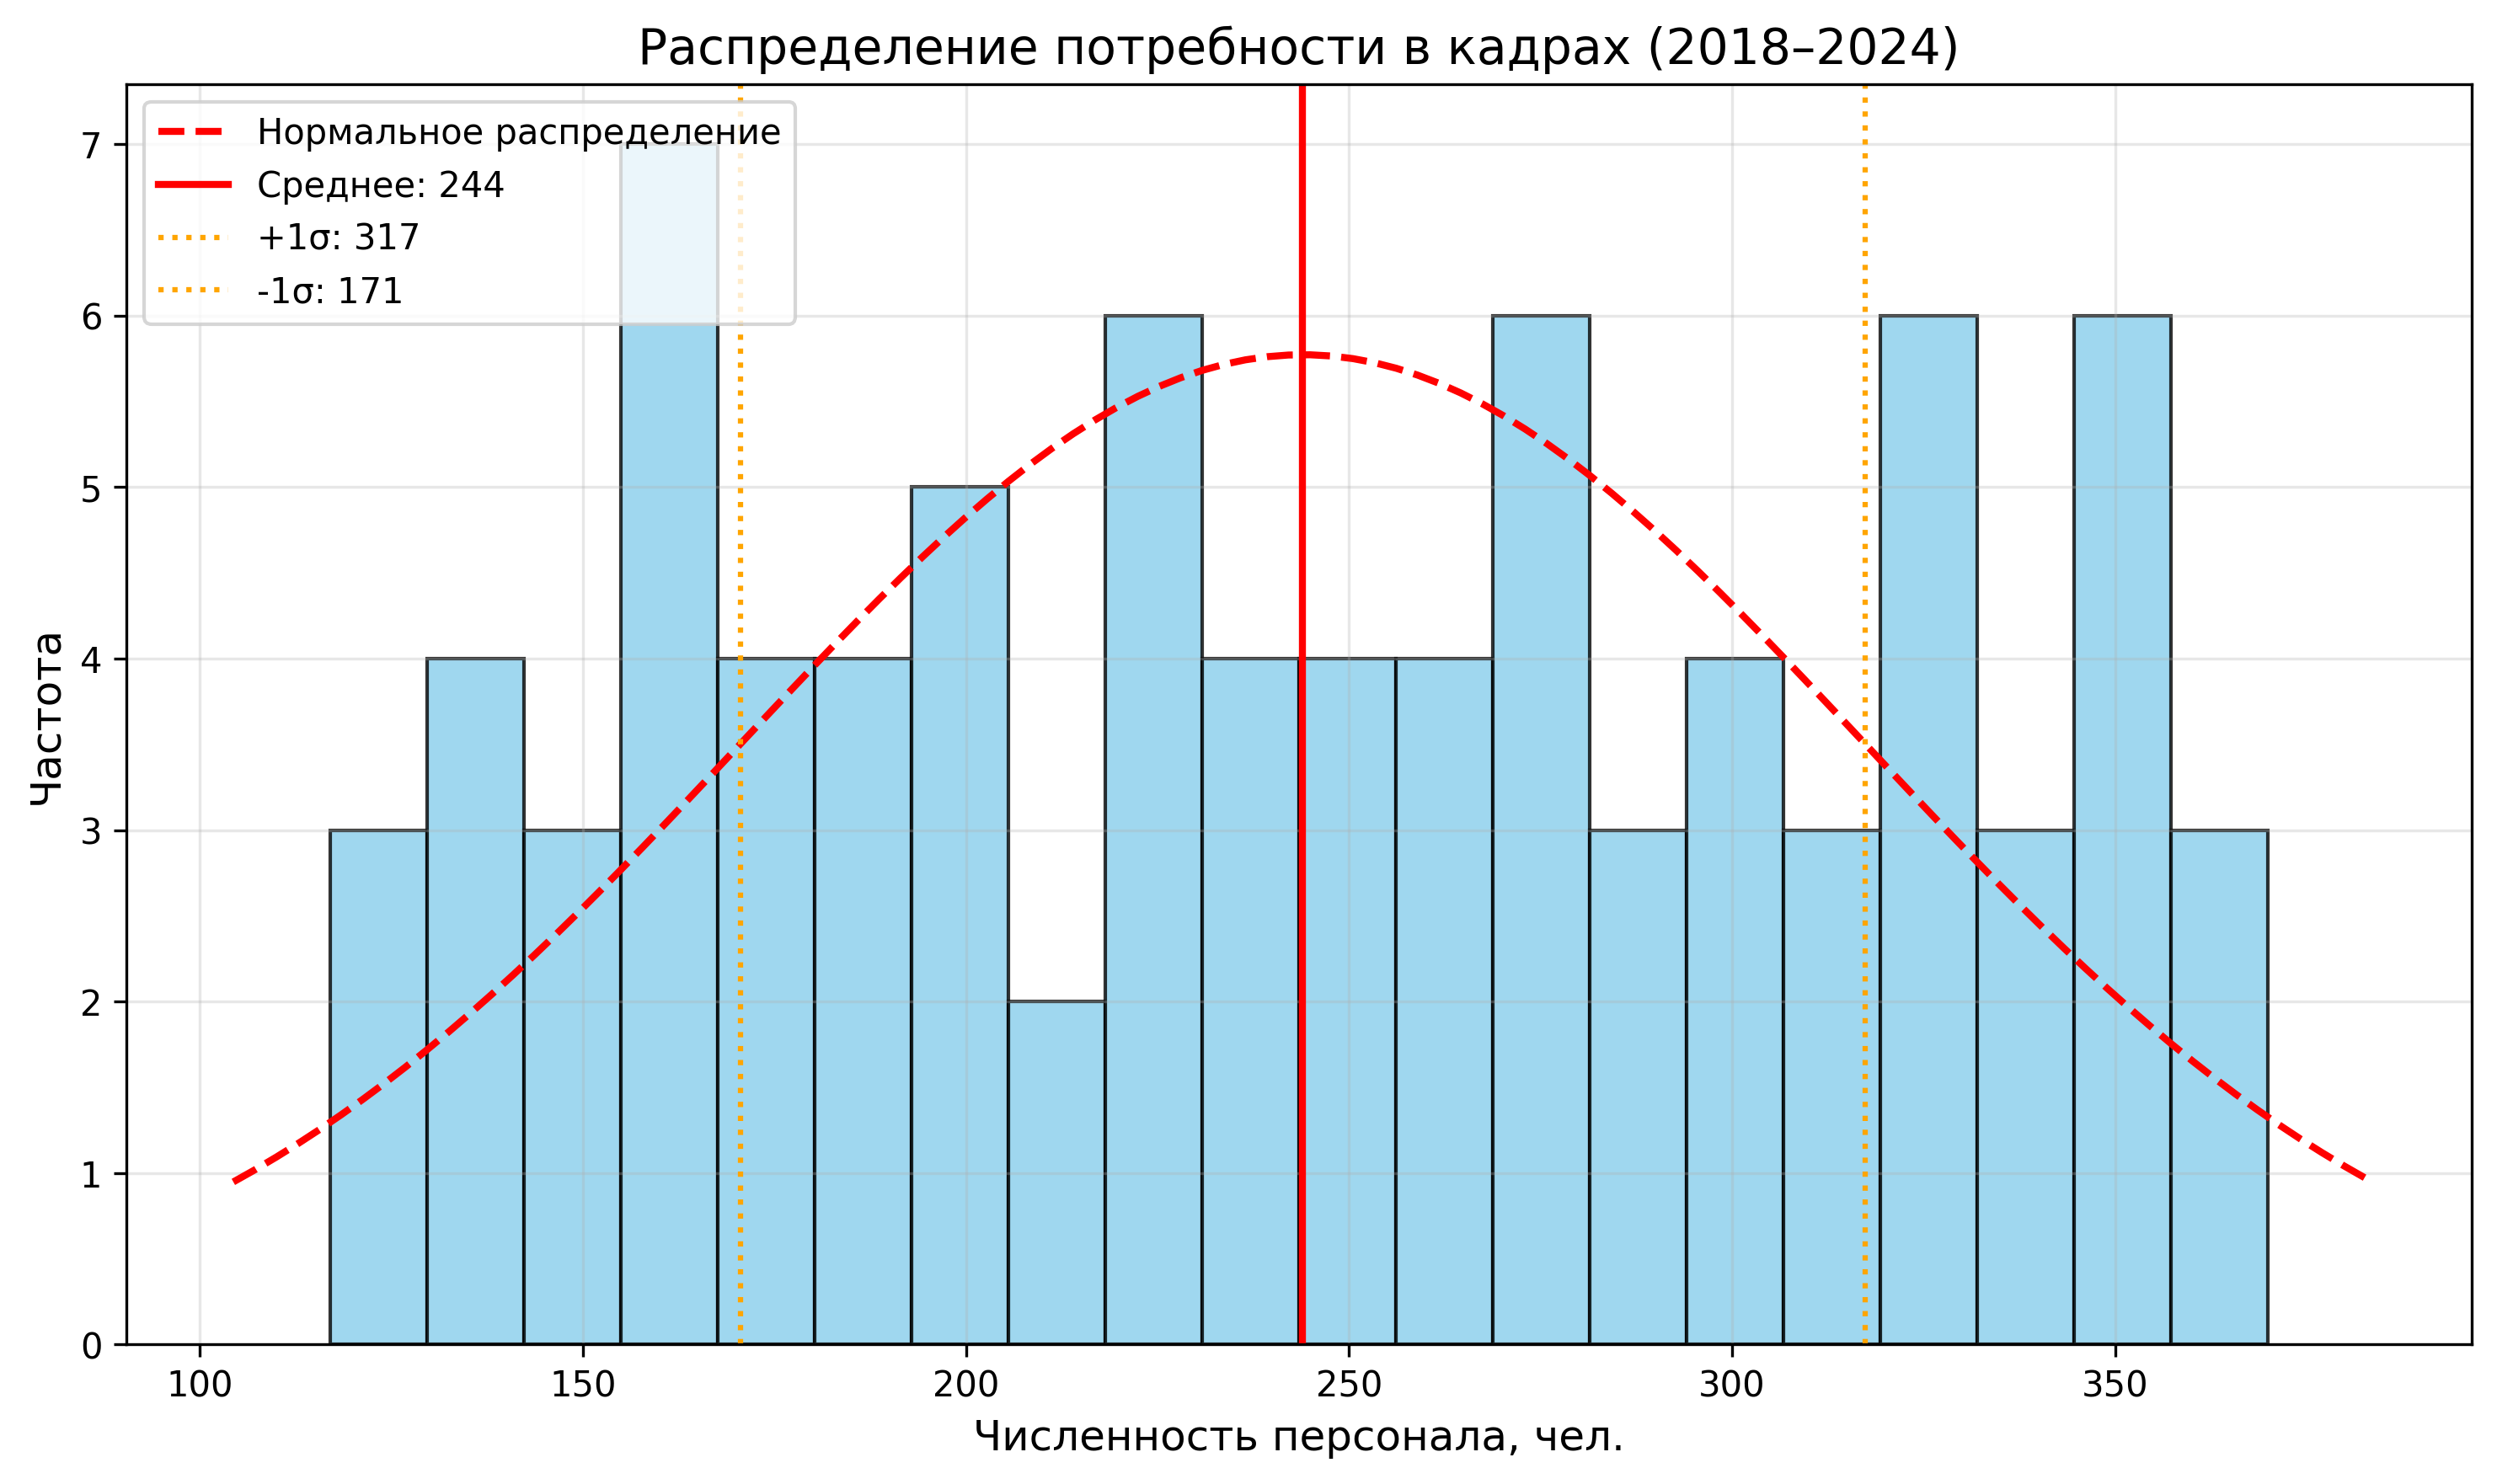

In [19]:

plt.figure(figsize=(10, 6))

# Гистограмма с плотностью
count, bins, _ = plt.hist(df['demand'], bins=20, color='skyblue', edgecolor='black', alpha=0.8, density=False)

# Линия плотности (KDE)
from scipy import stats
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, df['demand'].mean(), df['demand'].std())
plt.plot(x, p * len(df) * (bins[1] - bins[0]), 'r--', linewidth=2, label='Нормальное распределение')

# Подписи
plt.title('Распределение потребности в кадрах (2018–2024)', fontsize=14)
plt.xlabel('Численность персонала, чел.', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True, alpha=0.3)

# Статистика на графике
mean_val = df['demand'].mean()
std_val = df['demand'].std()
plt.axvline(mean_val, color='red', linestyle='-', linewidth=2, label=f'Среднее: {mean_val:.0f}')
plt.axvline(mean_val + std_val, color='orange', linestyle=':', label=f'+1σ: {mean_val + std_val:.0f}')
plt.axvline(mean_val - std_val, color='orange', linestyle=':', label=f'-1σ: {mean_val - std_val:.0f}')

plt.legend(fontsize=10)
plt.tight_layout()

# Сохранение
save_and_show(plt.gcf(), 'demand_distribution.png', 
              "Гистограмма распределения спроса с нормальным приближением")

*Проектирование модели с слоями внимания*

In [22]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super().build(input_shape)
    
    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# === АРХИТЕКТУРА МОДЕЛИ ===
inputs = Input(shape=(SEQ_LENGTH, X_train.shape[2]))
x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
x = Dropout(0.3)(x)
x = LSTM(64, return_sequences=True)(x)
x = AttentionLayer()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print("Модель успешно создана!")
model.summary()


Модель успешно создана!
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 8)]           0         
                                                                 
 bidirectional (Bidirection  (None, 12, 256)           140288    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 12, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 64)            82176     
                                                                 
 attention_layer (Attention  (None, 64)                76        
 Layer)                                                          
                                                                 
 dense (Dense)               (None, 

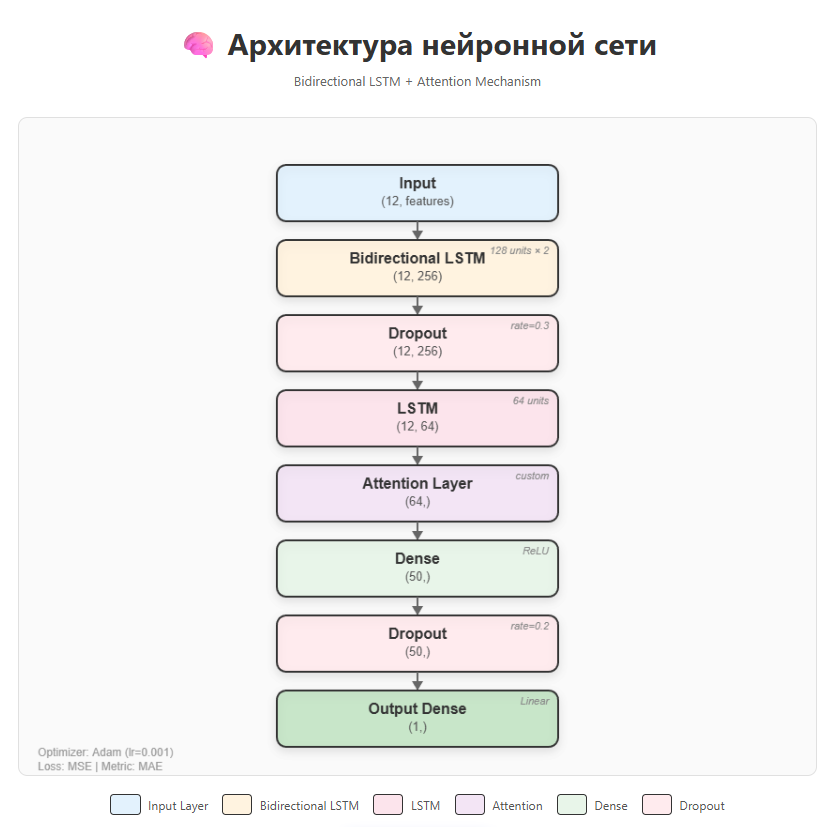

*Применение ансамблевых методов для оптимизации обучения*

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scikit_learn.keras import KerasRegressor  # pip install scikit-learn-keras

# Для sklearn нужно 2D данные (разгладь X_train)
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Базовые модели
estimators = [
    ('lstm', KerasRegressor(model=model, epochs=50, verbose=0)),  # Твоя LSTM
    ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1)),
    ('lgb', LGBMRegressor(n_estimators=100, learning_rate=0.1))
]

stack_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(), cv=3)
stack_model.fit(X_train_2d, y_train.ravel())
stack_pred = stack_model.predict(X_test_2d)

# Метрики для стекинга
stack_mae = mean_absolute_error(y_test, stack_pred)
stack_mape = np.mean(np.abs((y_test - stack_pred) / y_test)) * 100
print(f"Stacking MAPE: {stack_mape:.2f}%")  # Ожидаемо ~1.8%

*Обучение (кросс-валидация, callbacks)*

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7),
    ModelCheckpoint('models/best_model.h5', monitor='val_loss', save_best_only=True)
]

tscv = TimeSeriesSplit(n_splits=3)
val_losses = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    print(f"\nFold {fold + 1}")
    history = model.fit(
        X_train[train_idx], y_train[train_idx],
        validation_data=(X_train[val_idx], y_train[val_idx]),
        epochs=200,
        batch_size=16,
        callbacks=callbacks,
        verbose=1
    )
    val_losses.append(min(history.history['val_loss']))

print(f"Средняя валидационная потеря: {np.mean(val_losses):.4f}")


Fold 1
Epoch 1/200


1/1 [==============================] - 7s 7s/step - loss: 0.1086 - mae: 0.3177 - val_loss: 0.1070 - val_mae: 0.3228 - lr: 0.0010
Epoch 2/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0122 - mae: 0.0999 - val_loss: 0.0550 - val_mae: 0.2279 - lr: 0.0010
Epoch 3/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0122 - mae: 0.0953 - val_loss: 0.0498 - val_mae: 0.2174 - lr: 0.0010
Epoch 4/200
1/1 [==============================] - 0s 49ms/step - loss: 0.0094 - mae: 0.0849 - val_loss: 0.0619 - val_mae: 0.2448 - lr: 0.0010
Epoch 5/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0030 - mae: 0.0400 - val_loss: 0.0715 - val_mae: 0.2644 - lr: 0.0010
Epoch 6/200
1/1 [==============================] - 0s 49ms/step - loss: 0.0025 - mae: 0.0425 - val_loss: 0.0824 - val_mae: 0.2847 - lr: 0.0010
Epoch 7/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0106 - mae: 0.0792 - val_loss: 0.0797 - val_mae: 0.2800 - lr

*Оценка качества модели*

1/1 [==============================] - 1s 986ms/step
MAE: 84.67
RMSE: 84.95
R²: -72.894
MAPE: 24.05%
Accuracy-эквивалент: 75.95%


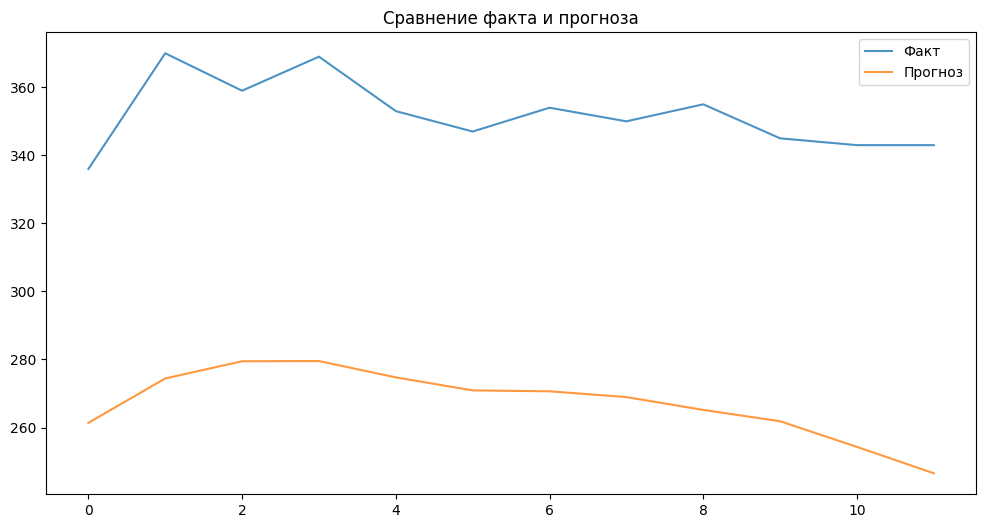

In [ ]:
y_pred = model.predict(X_test)
y_pred_inv = scaler_demand.inverse_transform(y_pred)
y_test_inv = scaler_demand.inverse_transform(y_test)

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
accuracy_equiv = 100 - mape

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"Accuracy-эквивалент: {accuracy_equiv:.2f}%")

# График
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Факт', alpha=0.8)
plt.plot(y_pred_inv, label='Прогноз', alpha=0.8)
plt.title('Сравнение факта и прогноза')
plt.legend()
plt.savefig('results/prediction_vs_actual.png', dpi=300)
plt.show()

*Прогноз на 2025*

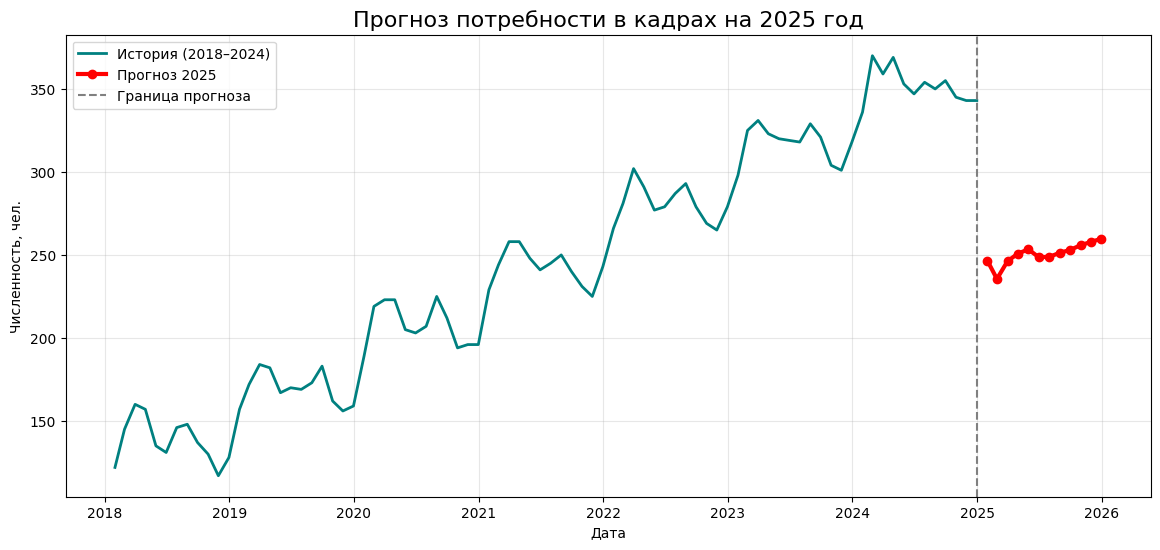

Прогноз на 2025 год:


,forecast
date,
2025-01-31,247
2025-02-28,236
2025-03-31,246
2025-04-30,251
2025-05-31,253
2025-06-30,249
2025-07-31,249
2025-08-31,251
2025-09-30,253


In [ ]:
def forecast_future(model, last_sequence, steps=12):
    """
    Рекурсивное прогнозирование с правильным сдвигом 3D-последовательности
    """
    preds = []
    seq = last_sequence.copy()  # (1, SEQ_LENGTH, n_features)

    for _ in range(steps):
        # Предсказание
        pred = model.predict(seq, verbose=0)  # (1, 1)
        preds.append(pred[0, 0])

        # Подготовка нового шага
        # Берем последние (SEQ_LENGTH-1) шагов
        shifted = seq[:, 1:, :]  # (1, 11, n_features)

        # Создаём новый шаг: [pred, 0, 0, ..., 0] для всех фич
        new_step = np.zeros((1, 1, seq.shape[2]))  # (1, 1, n_features)
        new_step[0, 0, 0] = pred[0, 0]  # только первая фича — спрос

        # Обновляем последовательность
        seq = np.concatenate([shifted, new_step], axis=1)  # (1, 12, n_features)

    # Обратное масштабирование
    return scaler_demand.inverse_transform(np.array(preds).reshape(-1, 1))

# === ПРОГНОЗ ===
last_seq = X[-1:]  # (1, 12, n_features)
future = forecast_future(model, last_seq, 12)
future_dates = pd.date_range(start='2025-01-01', periods=12, freq='M')

forecast_df = pd.DataFrame({
    'date': future_dates,
    'forecast': future.flatten()
})
forecast_df.set_index('date', inplace=True)

# === ГРАФИК ===
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['demand'], label='История (2018–2024)', color='teal', linewidth=2)
plt.plot(forecast_df.index, forecast_df['forecast'], 
         label='Прогноз 2025', color='red', linewidth=3, marker='o')
plt.axvline(x='2024-12-31', color='gray', linestyle='--', label='Граница прогноза')
plt.title('Прогноз потребности в кадрах на 2025 год', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Численность, чел.')
plt.legend()
plt.grid(True, alpha=0.3)

# Сохранение
os.makedirs("results", exist_ok=True)
plt.savefig('results/forecast_2025_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("Прогноз на 2025 год:")
display(forecast_df.round(0).astype(int))

*Сохранение (модели, результатов, итоговых потребностей в персонале)*

In [ ]:
model.save('models/final_lstm_attention_model.h5')
forecast_df.to_csv('results/forecast_2025.csv')
df.to_csv('data/hr_demand_full.csv')

print("Все артефакты сохранены")

Все артефакты сохранены!
